<a href="https://colab.research.google.com/github/adesgautam/grocery_obj_detection/blob/main/grocery_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the dependencies

### After running this cell restart the runtime

In [1]:
!pip uninstall tensorflow keras tensorflow-gpu -y
!pip install --upgrade --ignore-installed tensorflow-gpu==1.14.0 keras==2.2.4
!pip install h5py==2.10.0 mapcalc

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 43kB/s 
     |████████████████████████████████| 317kB 47.0MB/s 
     |████████████████████████████████| 1.0MB 51.1MB/s 
     |████████████████████████████████| 3.2MB 52.9MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 491kB 49.8MB/s 
     |████████████████████████████████| 4.1MB 46.1MB/s 
     |████████████████████████████████| 133kB 60.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 15.3MB 216kB/s 
     |████████████████████████████████| 4.1MB 49.7MB/s 
     |████████████████████████████████| 27.4MB 156kB/s 
     |████████████████████████████████| 645kB 49.8MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████

     |████████████████████████████████| 2.9MB 7.0MB/s 
  Created wheel for mapcalc: filename=mapcalc-0.2.1-cp37-none-any.whl size=5261 sha256=dd4093da73c2c82d76670e608a684fb67a0346e55811c38fc87f1389aa32307b
  Stored in directory: /root/.cache/pip/wheels/cf/55/af/041a4c0aab6d58f7e5b30f7182c7e94d5f2bd7bf54b07ba9a4
Successfully built mapcalc
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
  Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successfully uninstalled h5py-3.2.1


## Download Grocery Dataset

In [1]:
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz

In [2]:
!tar -xzf GroceryDataset_part1.tar.gz
!tar -xzf GroceryDataset_part2.tar.gz

# Prepare Dataset

## Imports

In [3]:
import os
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from PIL import Image

base_path = '/content/grocery_obj_detection/'

## Encode Labels
### Dump labels mappings

In [4]:
labels = ['Other', 'Marlboro', 'Kent', 'Camel',
          'Parliament', 'Pall Mall', 'Monte Carlo',
          'Winston', 'Lucky Strike', '2001', 'Lark']
int_to_label = {}
label_to_int = {}
for i,l in enumerate(labels):
    int_to_label[i] = l
    label_to_int[l] = i

print(int_to_label)

# Make classes file
classes_filename = 'data_classes.txt'
with open(classes_filename, "w") as file:
    for k,v in int_to_label.items():
        file.write(str(v)+'\n') 

{0: 'Other', 1: 'Marlboro', 2: 'Kent', 3: 'Camel', 4: 'Parliament', 5: 'Pall Mall', 6: 'Monte Carlo', 7: 'Winston', 8: 'Lucky Strike', 9: '2001', 10: 'Lark'}


## Create a Dataframe to store all the image details from ProductImagesFromShelves directory

In [5]:
shelf_images =  glob.glob('ShelfImages/*.JPG')
product_classes_dir = os.listdir('ProductImagesFromShelves')

product_images_data_li = []

product_images_data = {}
for class_dir in product_classes_dir:
    class_imgs = os.listdir('ProductImagesFromShelves/'+class_dir+'/')
    product_images_data[class_dir] = class_imgs

for k,v in product_images_data.items():
    for image_path in v:
        # for image path
        temp = image_path.split('JPG')
        # for other details
        img_details = temp[1].split('.')[0]
        img_details = img_details.split('_')[1:]
        # Get column img_name
        img_name = 'ShelfImages/' + temp[0]+'JPG'
        # Get image details for other columns
        xmin = img_details[0]
        ymin = img_details[1]
        width = img_details[2]
        height = img_details[3]
        class_name = k
        row = [
               img_name,
               int(xmin),
               int(ymin),
               int(xmin)+int(width),
               int(ymin)+int(height),
               class_name
        ]
        product_images_data_li.append(row)

### "product_images_data_df" contains the shelf image and the corresponding bounding boxes for the different classes

In [6]:
cols = ['image', 'xmin', 'ymin', 'xmax', 'ymax', 'code']
product_images_data_df = pd.DataFrame(product_images_data_li, columns=cols)
product_images_data_df.head()
# len(product_images_data_df)

,image,xmin,ymin,xmax,ymax,code
0,ShelfImages/C4_P01_N1_S3_1.JPG,1872,904,2060,1192,2
1,ShelfImages/C1_P07_N1_S3_1.JPG,1680,348,1872,648,2
2,ShelfImages/C4_P01_N1_S3_1.JPG,1444,904,1632,1192,2
3,ShelfImages/C2_P02_N3_S3_1.JPG,1772,196,1992,516,2
4,ShelfImages/C1_P07_N2_S3_1.JPG,100,404,304,700,2


### The data is skewed. 
### Instances of class 0 i.e., Other class is way higher than other classes.
### We can remove instances of Other class or can augement other classes to create more instances. For now we'll use the Other class as it is.

In [7]:
product_images_data_df['code'].value_counts()

0     10440
2       998
4       412
7       311
1       304
8       195
6       190
5       114
9        78
10       75
3        67
Name: code, dtype: int64

## Convert the Dataframe into YOLOv3 consumable format
### i.e., img_path xmin,ymin,xmax,ymax,class xmin,ymin,... n instances of objects in the image

In [8]:
## Get all bounding boxes for each shelf image
groups = product_images_data_df.groupby('image')

final_data = []
for g in groups:
    bbox_data = ''
    img_name = g[0]
    for row in g[1].iterrows():
        bbox_data += str(row[1]['xmin']) + ',' + \
                     str(row[1]['ymin']) + ',' + \
                     str(row[1]['xmax']) + ',' + \
                     str(row[1]['ymax']) + ',' + \
                     str(row[1]['code']) + ' '

    final_data.append([img_name, bbox_data[:-1]])

## Split for Train and Val

In [9]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(final_data, test_size=0.05, shuffle=True)

print('TRAIN images:', len(train_data))
print('VAL images:', len(val_data))

TRAIN images: 336
VAL images: 18


## Write data to disk

In [10]:
data_len = len(train_data)
with open('train.txt', 'w') as f:
    for i in range(data_len):
        txt = train_data[i][0] + ' ' + train_data[i][1]
        if i+1 != data_len:
            f.write( txt + '\n')
        else:
            f.write(txt)

data_len = len(val_data)
with open('val.txt', 'w') as f:
    for i in range(data_len):
        txt = val_data[i][0] + ' ' + val_data[i][1]
        if i+1 != data_len:
            f.write( txt + '\n')
        else:
            f.write(txt)

## Visualize Training Data

(1761, 3438, 3)


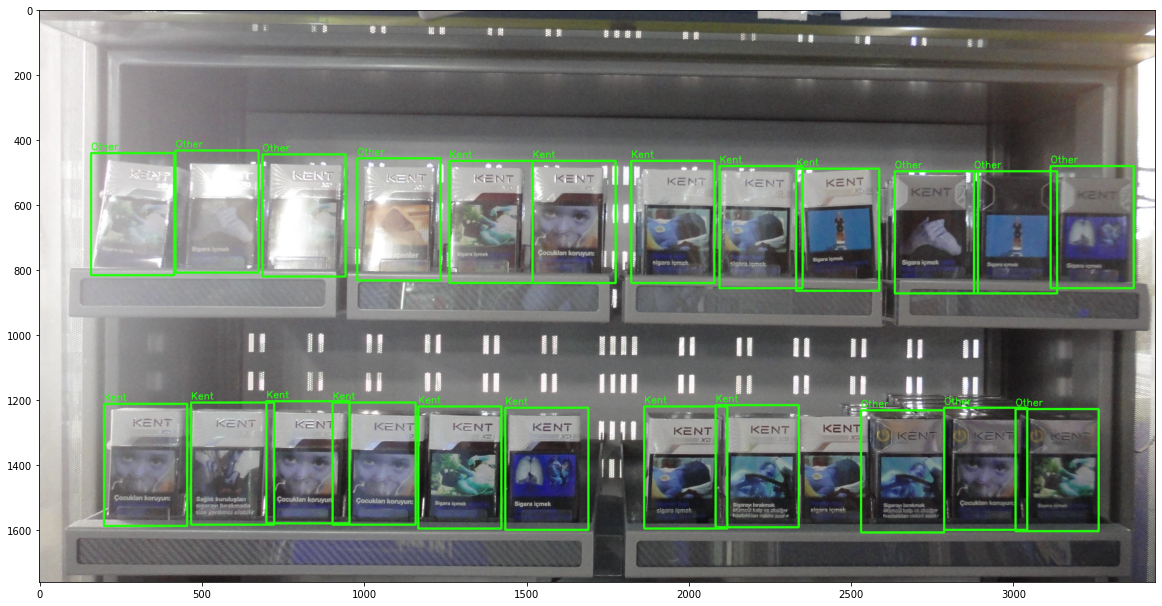

In [11]:
index = 1
image_data = val_data[index]
bbox_data = image_data[1].split(' ')

image = cv2.imread(image_data[0])
print(image.shape)

for bbox in bbox_data[1:]:
    tmp = bbox.split(',')
    x1 = int(tmp[0])
    y1 = int(tmp[1])
    x2 = int(tmp[2])
    y2 = int(tmp[3])
    
    label = int_to_label[int(tmp[4])]
        
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (36,255,12), 5)
    cv2.putText(image, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (36,255,12), 2)

plt.figure(figsize=(20,20))
plt.imshow(image)

# YOLOv3 for training

In [12]:
!git clone https://github.com/adesgautam/grocery_obj_detection.git

Cloning into 'grocery_obj_detection'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 11), reused 49 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), done.


## Download Darknet Weights

In [ ]:
import os
import subprocess
import time
import requests
import progressbar

yolo3_weights = base_path + 'models/yolov3.weights'

# Set URL
url = 'https://pjreddie.com/media/files/yolov3.weights'
r = requests.get(url,stream=True)

# Download yolo weights
f = open(yolo3_weights, 'wb')
file_size = int(r.headers.get('content-length'))
chunk = 100
num_bars = file_size // chunk
bar =  progressbar.ProgressBar(maxval=num_bars).start()
i = 0
for chunk in r.iter_content(chunk):
    f.write(chunk)
    bar.update(i)
    i+=1
f.close()

 99% (2475537 of 2480070) |############# | Elapsed Time: 0:00:37 ETA:   0:00:00

## Convert Darknet weights into Keras h5 format

In [ ]:
# Call for weights conversion
convert_file = base_path + 'keras_yolo3/convert.py'
yolo_config  = base_path + 'models/yolov3.cfg'
yolo_weights = base_path + 'models/yolov3.weights'
yolo_h5      = base_path + 'models/yolo.h5'

# Call subprocess for conversion from yolov3.weights to yolo.h5
call_string = 'python ' +convert_file+ ' ' +yolo_config+ ' ' +yolo_weights+ ' ' + yolo_h5
print("Calling subprocess:", call_string)
subprocess.call(call_string , shell=True)#, cwd = base_path)

Calling subprocess: python /content/grocery_obj_detection/keras_yolo3/convert.py /content/grocery_obj_detection/models/yolov3.cfg /content/grocery_obj_detection/models/yolov3.weights /content/grocery_obj_detection/models/yolo.h5


0

## Train YOLOv3

## You can load the pretrained weights finetuned on this dataset from here: 
### https://drive.google.com/file/d/1-KFW4WjhrpQGxp-UMB1LB38m_YNLdPXw/view?usp=sharing

## OR you can use the original yolov3 weights to train from scratch in models/yolo.h5

In [ ]:
import os
import numpy as np
import pickle
import keras.backend as K

from PIL import Image
from time import time
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from grocery_obj_detection.keras_yolo3.yolo3.model import preprocess_true_boxes, yolo_body, yolo_loss
from grocery_obj_detection.keras_yolo3.yolo3.utils import get_random_data
from grocery_obj_detection.train_utils import get_classes, get_anchors, create_model, data_generator, data_generator_wrapper, ChangeToOtherMachine

import keras.backend as K
K.clear_session()

# Setup directories and filenames
YOLO_train_file = 'train.txt'
classes_file = 'data_classes.txt'
log_dir = 'model_logs'
anchors_path = base_path + 'yolo_anchors.txt'
weights_path = '/model_logs/yolo.h5'

if not os.path.exists(log_dir):
    os.mkdir(log_dir)

## Hyperparameters
# multiple of 32, height, width
input_shape = (416, 416)
test_split = 0.2
random_seed = 0

## Checkpoint settings
save_best_model_only = True
model_save_per_epochs = 1

# Set random seed
np.random.seed(random_seed)

class_names = get_classes(classes_file)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path = weights_path) 

# Setup logging
log_dir_time = os.path.join(log_dir,'{}'.format(int(time())))
logging = TensorBoard(log_dir = log_dir_time)

# Create callbacks
# _{epoch:02d}_{val_loss:.2f}
checkpoint = ModelCheckpoint(os.path.join(log_dir,'checkpoint.h5'),
                                            monitor = 'val_loss', 
                                            save_weights_only = True, 
                                            save_best_only = save_best_model_only, 
                                            period = model_save_per_epochs)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

## Read training data
with open(YOLO_train_file) as f:
    lines = f.read()

lines = lines.split('\n')

## Split Train and Test data
np.random.shuffle(lines)
num_test = int(len(lines)*test_split)
num_train = len(lines) - num_test

lr1 = 1e-3
model.compile(optimizer=Adam(lr=lr1), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

Create YOLOv3 model with 9 anchors and 11 classes.
Load weights /content/model_logs/trained_weights_final_finetuned_92.63943276476505_valloss_94.91487240791321.h5.
Freeze the first 249 layers of total 252 layers.


## Start Training

In [ ]:
## Hyperparams
batch_size = 32
epochs = 60

# Train with frozen layers first, to get a stable loss.
## Train Stage 1 (for making a stable model first)

print('Training on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_test, batch_size))
history = model.fit_generator(
                        data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                        steps_per_epoch=max(1, num_train//batch_size),
                        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                        validation_steps=max(1, num_test//batch_size),
                        epochs=epochs,
                        initial_epoch=0,
                        callbacks=[logging, checkpoint]
                        )

# Save stage 1 model by with loss in filename
step1_train_loss = history.history['loss']
step1_val_loss = history.history['val_loss']

last_train_loss = step1_train_loss[-2] if step1_train_loss[-1]=='' else step1_train_loss[-1]
last_val_loss = step1_val_loss[-2] if step1_val_loss[-1]=='' else step1_val_loss[-1]

# Save stage 1 model
model.save_weights(os.path.join(log_dir,'trained_weights_stage_1_trainloss_'+ 
                                        str(last_train_loss) + '_valloss_' + str(last_val_loss) + '.h5'))

Training on 269 samples, val on 67 samples, with batch size 32.
Epoch 1/60
8/8 [==============================] - 97s 12s/step - loss: 8791.1093 - val_loss: 5387.5188
Epoch 2/60
8/8 [==============================] - 48s 6s/step - loss: 3920.1072 - val_loss: 2472.5664
Epoch 3/60
8/8 [==============================] - 65s 8s/step - loss: 1991.0661 - val_loss: 1368.5563
Epoch 4/60
8/8 [==============================] - 65s 8s/step - loss: 1213.1559 - val_loss: 852.6730
Epoch 5/60
8/8 [==============================] - 64s 8s/step - loss: 843.7302 - val_loss: 662.3113
Epoch 6/60
8/8 [==============================] - 65s 8s/step - loss: 666.5120 - val_loss: 536.8030
Epoch 7/60
8/8 [==============================] - 65s 8s/step - loss: 556.8137 - val_loss: 480.3270
Epoch 8/60
8/8 [==============================] - 65s 8s/step - loss: 501.0155 - val_loss: 436.2705
Epoch 9/60
8/8 [==============================] - 64s 8s/step - loss: 449.1639 - val_loss: 382.1982
Epoch 10/60
8/8 [===========

In [13]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(range(1,epochs+1), step1_train_loss, label='Train Loss')
plt.plot(range(1,epochs+1), step1_val_loss, label='Val Loss')
plt.legend()
plt.show

In [ ]:
## Fine tuning settings
fine_tune = True
ft_batch_size = 4
lr2 = 1e-4
ft_epochs = epochs+epochs

## Fine tune the stage 1 model    
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is unsatisfactory.
if fine_tune:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=lr2), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 
    print('Unfreezing all layers...')

    batch_size = ft_batch_size # note that more GPU memory is required after unfreezing the body
    print('Training on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_test, batch_size))
    history = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                steps_per_epoch=max(1, num_train//batch_size),
                                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                validation_steps=max(1, num_test//batch_size),
                                epochs=ft_epochs,
                                initial_epoch=epochs,
                                callbacks=[logging, checkpoint, reduce_lr, early_stopping])

    # Save fine tuned model by with loss in filename
    step2_train_loss = history.history['loss']
    step2_val_loss = history.history['val_loss']

    last_train_loss = step2_train_loss[-2] if step2_train_loss[-1]=='' else step2_train_loss[-1]
    last_val_loss = step2_val_loss[-2] if step2_val_loss[-1]=='' else step2_val_loss[-1]

    # Save fine tuned model
    model.save_weights(os.path.join(log_dir,'trained_weights_final_finetuned_'+ 
                                            str(last_train_loss) + '_valloss_' + str(last_val_loss) + '.h5'))
    

Unfreezing all layers...
Training on 269 samples, val on 67 samples, with batch size 4.
Epoch 1/50
67/67 [==============================] - 85s 1s/step - loss: 97.0732 - val_loss: 98.2035
Epoch 2/50
67/67 [==============================] - 64s 958ms/step - loss: 97.6735 - val_loss: 97.0869
Epoch 3/50
67/67 [==============================] - 73s 1s/step - loss: 93.8783 - val_loss: 98.5943
Epoch 4/50
67/67 [==============================] - 74s 1s/step - loss: 93.6366 - val_loss: 97.0627
Epoch 5/50
67/67 [==============================] - 73s 1s/step - loss: 93.8746 - val_loss: 98.2517
Epoch 6/50
67/67 [==============================] - 75s 1s/step - loss: 94.2939 - val_loss: 94.8080
Epoch 7/50
67/67 [==============================] - 73s 1s/step - loss: 94.5306 - val_loss: 96.4435
Epoch 8/50
67/67 [==============================] - 74s 1s/step - loss: 93.6371 - val_loss: 101.9963
Epoch 9/50
67/67 [==============================] - 74s 1s/step - loss: 91.8375 - val_loss: 96.0572

Epoch 0

KeyboardInterrupt: ignored

# Visualize Predictions and Calculate mAP on val data

### Load Pretrained model for the dataset. 
#### Link: https://drive.google.com/file/d/1-KFW4WjhrpQGxp-UMB1LB38m_YNLdPXw/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import random
import keras.backend as K

from timeit import default_timer as timer
from grocery_obj_detection.keras_yolo3.yolo import YOLO, detect_video
from grocery_obj_detection.utils import load_extractor_model, load_features, parse_input, detect_object
from grocery_obj_detection.get_file_paths import GetFileList

print("Starting...")
K.clear_session()

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

input_path = "test"
output_path = "test"

if not os.path.exists(output_path):
    os.mkdir(output_path)

anchors_path = base_path + "yolo_anchors.txt"
classes_path = "data_classes.txt"
## This is the pretrained weight file from drive
model_path = "/content/trained_weights_final_finetuned_val_loss_92.h5"

score = 0.25
gpu_num = 1
postfix = "_text"
save_img = True

print("Loading Model...")
# Define YOLO detector
yolo = YOLO(**{"model_path": model_path,
                "anchors_path": anchors_path,
                "classes_path": classes_path,
                "score" : score,
                "gpu_num" : gpu_num,
                "model_image_size" : (416, 416),
                })
print("Model Loaded!")

# Labels to draw on images
class_file = open(classes_path, 'r')
input_labels = [line.rstrip('\n') for line in class_file.readlines()]
print('Found {} input labels: {} ...'.format(len(input_labels), input_labels))


def predict_image(img_path):
    print(img_path)

    # Make a dataframe for the prediction outputs
    out_df = pd.DataFrame(columns=['image', 'image_path','xmin', 'ymin', 'xmax', 'ymax', 'label','confidence','x_size','y_size'])

    prediction, image = detect_object(yolo, img_path, save_img = save_img,
                                        save_img_path = output_path,
                                        postfix=postfix) 

    y_size, x_size, _ = np.array(image).shape
    cols = ['image','image_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label','confidence','x_size','y_size']
    for single_prediction in prediction:
        out_df = out_df.append(pd.DataFrame([[os.path.basename(img_path.rstrip('\n')),
                                              img_path.rstrip('\n')]+single_prediction + [x_size,y_size]], 
                                            columns=cols))
    return out_df

Starting...
Loading Model...
/content/trained_weights_final_finetuned_val_loss_92.h5 model, anchors, and classes loaded in 9.33sec.
Model Loaded!
Found 11 input labels: ['Other', 'Marlboro', 'Kent', 'Camel', 'Parliament', 'Pall Mall', 'Monte Carlo', 'Winston', 'Lucky Strike', '2001', 'Lark'] ...


## Structure validation data from val.txt

In [ ]:
val_data_li = []

val_data = ''
with open('val.txt', 'r') as f:
    val_data = f.read().split('\n')

for data in val_data:
    tmp = data.split(' ')
    img_path = tmp[0]

    for box in tmp[1:]:
        tmp_box = box.split(',')
        val_data_li.append([img_path, 
                            int(tmp_box[0]), 
                            int(tmp_box[1]),
                            int(tmp_box[2]),
                            int(tmp_box[3]),
                            int(tmp_box[4])
                            ])
        
cols = ['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']
val_data_df = pd.DataFrame(val_data_li, columns=cols)

val_images = val_data_df['img_path'].tolist()
val_images = set(val_images)

## Visualize Predictions

### Predict on Single Image

ShelfImages/C4_P05_N3_S3_1.JPG
img_path ShelfImages/C4_P05_N3_S3_1.JPG
(416, 416, 3)
Found 23 boxes for img
Parliament 0.62 (2320, 238) (2540, 568)
Parliament 0.66 (2139, 208) (2327, 571)
Parliament 0.68 (732, 258) (922, 564)
Other 0.55 (1316, 240) (1518, 552)
Other 0.55 (1512, 795) (1709, 1096)
Other 0.55 (1335, 1280) (1520, 1609)
Other 0.56 (1525, 241) (1735, 556)
Other 0.56 (1900, 779) (2089, 1092)
Other 0.58 (1928, 1293) (2149, 1616)
Other 0.58 (1732, 248) (1930, 559)
Other 0.58 (2334, 1287) (2543, 1606)
Other 0.58 (168, 758) (347, 1071)
Other 0.58 (1099, 783) (1301, 1095)
Other 0.60 (540, 743) (725, 1069)
Other 0.61 (917, 254) (1138, 561)
Other 0.62 (2141, 1285) (2346, 1619)
Other 0.62 (900, 751) (1075, 1084)
Other 0.62 (725, 726) (898, 1090)
Other 0.64 (1929, 237) (2129, 571)
Other 0.64 (542, 230) (734, 554)
Other 0.66 (350, 752) (537, 1067)
Other 0.68 (167, 226) (353, 542)
Other 0.70 (361, 231) (538, 553)
Time spent: 0.170sec
[[2320, 238, 2540, 568, 4, 0.6230066], [2139, 208, 23

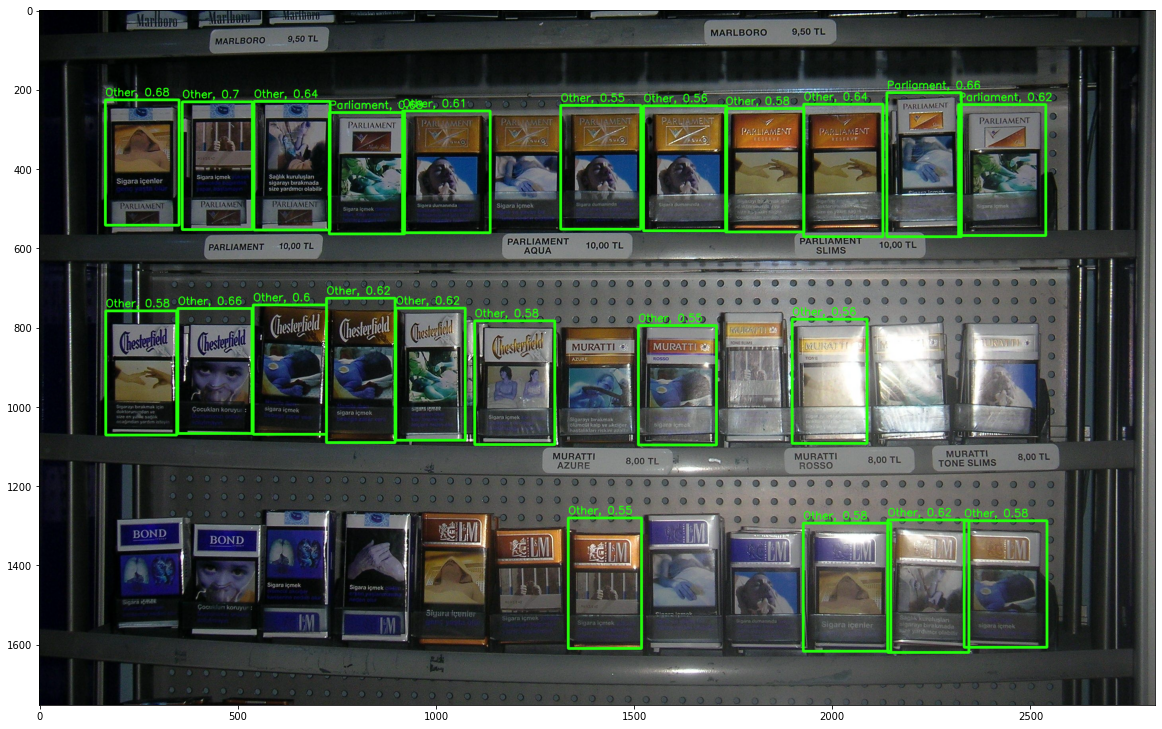

In [ ]:
image_path = list(val_images)[2]
# print(image_path)

out_df = predict_image(image_path)

image = cv2.imread(image_path)

for row in out_df.iterrows():
    row = row[1]

    x1 = row[2]
    y1 = row[3]
    x2 = row[4]# - row[2]
    y2 = row[5]# - row[3]

    conf = round(row[7], 2)
    label = int_to_label[row[6]] + ', ' + str(conf)
    
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (36,255,12), 5)
    cv2.putText(image, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

plt.figure(figsize=(20,20))
plt.imshow(image)

## Calculate mAP

In [ ]:
from mapcalc import calculate_map

iou_thresh = 0.5

images_map = []

start = timer()
for image_path in list(val_images):

    gt_boxes = []
    gt_labels = []

    pred_boxes = []
    pred_labels = []
    pred_confs = []
    
    ## Get prediction on image
    out_df = predict_image(image_path)
    out_df = out_df.sort_values(['ymin', 'xmin'], axis=0)

    ## get prediction  bboxes, labels and confidences
    for row in out_df.iterrows():
        row = row[1]

        x1 = row[2]
        x2 = row[4]
        y1 = row[3]
        y2 = row[5]
        label = row[6]
        conf = row[7]

        pred_boxes.append([x1, x2, y1, y2])
        pred_labels.append(label)
        pred_confs.append(conf)

    gt_li = []
    ## get GT boxes and labels
    gt_rows = val_data_df[val_data_df['img_path']==image_path]
    for row in gt_rows.iterrows():
        row = row[1]

        x1 = row[1]
        y1 = row[2]
        x2 = row[3]
        y2 = row[4]
        label = row[5]

        gt_boxes.append([x1, x2, y1, y2])
        gt_labels.append(label)
        gt_li.append([image_path, x1, y1, x2, y2, label])

    gt_df = pd.DataFrame(gt_li, columns=['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])
    gt_df = gt_df.sort_values(['ymin', 'xmin'], axis=0)

    image = cv2.imread(image_path)

    ## Display predictions
    for row in out_df.iterrows():
        row = row[1]

        x1 = row[2]
        y1 = row[3]
        x2 = row[4]
        y2 = row[5]
        conf = round(row[7], 2)
        label = int_to_label[row[6]] + ', ' + str(conf)

        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 5)
        cv2.putText(image, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


    ## Display GT
    for row in gt_df.iterrows():
        row = row[1]

        x1 = row[1]
        y1 = row[2]
        x2 = row[3]
        y2 = row[4]
        label = int_to_label[row[5]]

        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 5)
        cv2.putText(image, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    ## Uncomment to view images
    # plt.figure(figsize=(20,20))
    # plt.imshow(image)

    ## Calculate mAP
    ground_truth = {
        'boxes': gt_boxes,
        'labels': gt_labels
        }

    result_dict = {
        'boxes': pred_boxes,
        'labels': pred_labels,
        'scores': pred_confs
            }

    # calculate the mAP for an IOU threshold of 0.5
    image_map =  calculate_map(ground_truth, result_dict, iou_thresh)
    images_map.append(image_map)

end = timer()
print('Processed validation images in {:.1f}secs'.format(end-start))

ShelfImages/C4_P06_N1_S3_1.JPG
img_path ShelfImages/C4_P06_N1_S3_1.JPG
(416, 416, 3)
Found 24 boxes for img
Parliament 0.46 (625, 1504) (851, 1846)
Parliament 0.50 (2084, 1462) (2279, 1834)
Marlboro 0.27 (1101, 964) (1298, 1304)
Marlboro 0.31 (685, 967) (881, 1302)
Other 0.51 (1870, 1509) (2072, 1839)
Other 0.52 (1458, 1520) (1665, 1832)
Other 0.53 (2284, 1511) (2502, 1842)
Other 0.54 (1673, 1521) (1873, 1832)
Other 0.56 (2110, 406) (2331, 661)
Other 0.58 (1108, 354) (1307, 659)
Other 0.58 (1695, 962) (1913, 1305)
Other 0.59 (1919, 395) (2114, 659)
Other 0.59 (694, 369) (908, 662)
Other 0.59 (1904, 971) (2130, 1299)
Other 0.59 (2319, 410) (2581, 666)
Other 0.60 (1297, 935) (1502, 1287)
Other 0.60 (1724, 378) (1904, 660)
Other 0.61 (440, 1479) (651, 1808)
Other 0.61 (304, 944) (491, 1283)
Other 0.63 (505, 380) (701, 682)
Other 0.63 (51, 1458) (241, 1806)
Other 0.65 (2117, 963) (2327, 1311)
Other 0.67 (255, 1456) (446, 1820)
Other 0.71 (2307, 970) (2546, 1301)
Time spent: 0.181sec
[[625,

## Average mAP accross all images

In [ ]:
map_sum = sum(images_map)
final_map = map_sum/len(images_map)

print('Final mAP', final_map)

Final mAP 0.13909831365657543


## With more training the mAP can be improved